In [181]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/titanic.csv',index_col = 'PassengerId')

# df_test = pd.read_csv('/content/test.csv',index_col = 'PassengerId')

In [182]:
df.shape

(891, 11)

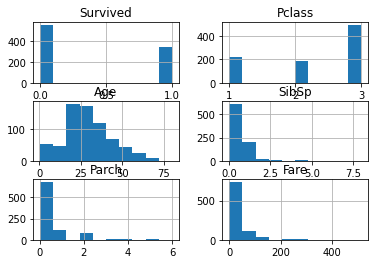

In [183]:
_ = df.hist()

In [147]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [148]:
import plotly.express as px
fig = px.scatter(df, x='Cabin', y='Embarked', title='Relasi Hubungan pengisian Cabin dan Embarked')
fig.show()

dari relasi diatas dapat kita tarik kesimpulan rute titanic Southampton - Cherbourg - Queenstown dan setelah melakukan research hal tersebut benar

berikut korelasi antar fitur dan target

In [149]:
import seaborn as sns

_ = sns.heatmap(df.corr(),annot=True)

In [150]:
df['Embarked'].isna().sum()
df[df['Embarked'].isna()]

Survived  Pclass  ... Cabin Embarked
PassengerId                    ...               
62                  1       1  ...   B28      NaN
830                 1       1  ...   B28      NaN

[2 rows x 11 columns]

disini ditemukan terdapat 2 datapoint dengan na pada kolomn embarked nya, data point dapat diusahakan dengan mencari kesamaan dari datapoint lain. Kita berusaha untuk membaca pola yang sudah ad dari data.

In [151]:
df[( 80 == df['Fare']) | (df['Cabin']== 'B28')]

Survived  Pclass  ... Cabin Embarked
PassengerId                    ...               
62                  1       1  ...   B28      NaN
830                 1       1  ...   B28      NaN

[2 rows x 11 columns]

Karena Cabin berdasarkan relasi diatas cenderung unik untuk setiap penumpang dan fare jg berbeda dari passenger lain kita akan melakukan googling dan menemukan icard miss amelie dan george nelson kedua ny berasal dari Southampton. 

"She boarded the Titanic at Southampton as maid to Mrs George Nelson Stone. Mrs Stone and Miss Icard..."

https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.

In [152]:
df.loc[df['Embarked'].isna(),'Embarked'] ='S'

In [153]:
df['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [154]:
print(len(df['Ticket'].unique()))

681


kolomn tiket di temukan unique sebanyak kurang lebi > 2/3 data keseluruhan
dan memiliki kategori sebanyak 681/891

In [155]:
df.groupby('Ticket').count()

Survived  Pclass  Name  Sex  ...  Parch  Fare  Cabin  Embarked
Ticket                                    ...                              
110152              3       3     3    3  ...      3     3      3         3
110413              3       3     3    3  ...      3     3      3         3
110465              2       2     2    2  ...      2     2      2         2
110564              1       1     1    1  ...      1     1      1         1
110813              1       1     1    1  ...      1     1      1         1
...               ...     ...   ...  ...  ...    ...   ...    ...       ...
W./C. 6608          4       4     4    4  ...      4     4      0         4
W./C. 6609          1       1     1    1  ...      1     1      0         1
W.E.P. 5734         1       1     1    1  ...      1     1      1         1
W/C 14208           1       1     1    1  ...      1     1      0         1
WE/P 5735           2       2     2    2  ...      2     2      2         2

[681 rows x 10 columns]

disini ditemukan ada kesamaan tiket yang berati penumpang embarked titanic bersamaan atau saling mengenal, info ini juga merepresentasikan kesamaan cabin/hubungan keluarga untuk penyerdehaan kolomn ticket akan kita sederhanakan menjadi jumla kesamaan kawan berangkat

In [ ]:
ticket = list((df.groupby('Ticket').count()-1).to_dict().values())[0]

In [157]:
df['Ticket'] = [ ticket[i] for i in df['Ticket'] ]

In [158]:
print(df['Cabin'].isna().sum())
len(df['Cabin'].unique())

687


148

untuk column cabin terdapat 687 data yang na disertai 147 kategori dari 204 data sehingga bole di drop

In [159]:
df.drop(columns='Cabin',axis=1,inplace=True)

selanjut nya akan dilakukan drop name,imputasi data kosong dan mengubah kolomn sex menjadi categorial

In [160]:
df.drop(columns='Name',axis=1,inplace=True)

In [161]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

In [162]:
df['Sex'] = df['Sex'].astype('category').cat.codes

In [163]:
df['Ticket'] = df['Ticket'].fillna(0)

In [164]:
df['Fare'] = df['Fare'].fillna(df['Fare'].mean())

encode category embarked

In [165]:
from sklearn.preprocessing import OneHotEncoder

OHencoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
embarked_OH =  pd.DataFrame(OHencoder.fit_transform(df[['Embarked']]))
embarked_OH.index = df.index

df.drop('Embarked',axis=1,inplace=True)
df = pd.concat([df,embarked_OH],axis=1)
df

Survived  Pclass  Sex        Age  ...     Fare    0    1    2
PassengerId                                    ...                        
1                   0       3    1  22.000000  ...   7.2500  0.0  0.0  1.0
2                   1       1    0  38.000000  ...  71.2833  1.0  0.0  0.0
3                   1       3    0  26.000000  ...   7.9250  0.0  0.0  1.0
4                   1       1    0  35.000000  ...  53.1000  0.0  0.0  1.0
5                   0       3    1  35.000000  ...   8.0500  0.0  0.0  1.0
...               ...     ...  ...        ...  ...      ...  ...  ...  ...
887                 0       2    1  27.000000  ...  13.0000  0.0  0.0  1.0
888                 1       1    0  19.000000  ...  30.0000  0.0  0.0  1.0
889                 0       3    0  29.699118  ...  23.4500  0.0  0.0  1.0
890                 1       1    1  26.000000  ...  30.0000  1.0  0.0  0.0
891                 0       3    1  32.000000  ...   7.7500  0.0  1.0  0.0

[891 rows x 11 columns]

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error



seed = 7
X = df.drop('Survived',axis=1)
y = df['Survived']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=seed)

print(X_train,y_train)

model = LogisticRegression(max_iter=345)

model.fit(X_train,y_train.ravel())

predict = model.predict(X_test)

             Pclass  Sex        Age  SibSp  ...      Fare    0    1    2
PassengerId                                 ...                         
206               3    0   2.000000      0  ...   10.4625  0.0  0.0  1.0
719               3    1  29.699118      0  ...   15.5000  0.0  1.0  0.0
836               1    0  39.000000      1  ...   83.1583  1.0  0.0  0.0
852               3    1  74.000000      0  ...    7.7750  0.0  0.0  1.0
774               3    1  29.699118      0  ...    7.2250  1.0  0.0  0.0
...             ...  ...        ...    ...  ...       ...  ...  ...  ...
580               3    1  32.000000      0  ...    7.9250  0.0  0.0  1.0
503               3    0  29.699118      0  ...    7.6292  0.0  1.0  0.0
538               1    0  30.000000      0  ...  106.4250  1.0  0.0  0.0
197               3    1  29.699118      0  ...    7.7500  0.0  1.0  0.0
176               3    1  18.000000      1  ...    7.8542  0.0  0.0  1.0

[712 rows x 10 columns] PassengerId
206    0
719  

In [172]:
print(model.coef_)
# print(mean_absolute_error(predict,y_test))
# print(mean_squared_error(predict,y_test))
# print(mean_squared_error(predict,y_test,squared=False))
print(model.score(X_test,y_test))

[[-1.02617217e+00 -2.83956073e+00 -4.55732784e-02 -2.70998836e-01
   1.57633435e-01 -2.25252830e-01  2.25038674e-03  2.48665762e-01
   3.51919775e-02 -2.79206315e-01]]
0.7597765363128491


In [168]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics

In [169]:
print('Accuracy: ', accuracy_score(y_test, predict))
print('ROC-AUC Score: ', roc_auc_score(y_test, predict))

Accuracy:  0.7597765363128491
ROC-AUC Score:  0.7370223978919631


In [170]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       110
           1       0.71      0.64      0.67        69

    accuracy                           0.76       179
   macro avg       0.75      0.74      0.74       179
weighted avg       0.76      0.76      0.76       179



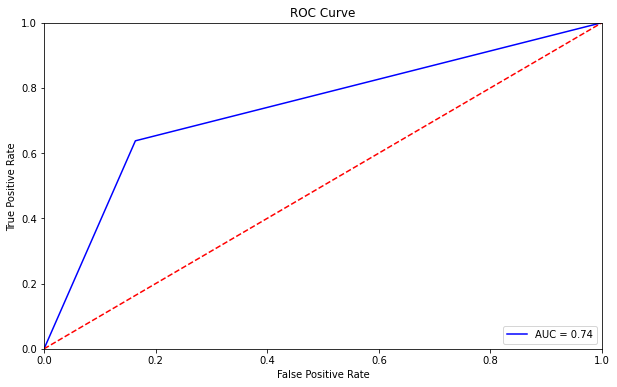

In [171]:
import matplotlib.pyplot as plt


fpr, tpr, threshold = metrics.roc_curve(y_test, predict)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()